In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import tqdm
import faiss
import time
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from skimage import measure
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse


In [3]:
vgg16 = VGG16(include_top=False,weights='imagenet',pooling='avg',input_shape=(224,224,3))

2023-04-25 19:12:23.986819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
image_list =  glob.glob('/Users/shanghuahao/Desktop/RiceU/COMP646/Final_Project/Images/JPEGImages/*.jpg')
print(len(image_list))

class FeatureExtract_VGG16:
    def __init__(self):

        self.vgg16 = VGG16(weights='imagenet', include_top=False,pooling='avg',input_shape=(224,224,3))
    
    # function to extract features from images
    def extractFeat(self,fileName):
        img = image.load_img(fileName, target_size=(224, 224))
        img_array = image.img_to_array(img)
        # expand_dims for image
        img_array = np.expand_dims(img_array, axis=0)
        # preprocess the image
        img_array = preprocess_input(img_array)
        # extract features of the image using vgg16
        feat = self.vgg16.predict(img_array)
        # L2
        feat = feat[0] / np.linalg.norm(feat[0])

        return feat

18906


In [7]:
#feature extraction for images
feature_extract_vgg16 = FeatureExtract_VGG16()
feat_list_vgg16 = []

name_list_vgg = []
i = 0
for img_file in image_list:
    # feature extract for each image
    feat_vec = feature_extract_vgg16.extractFeat(img_file)
    # store all image features
    feat_list_vgg16.append(feat_vec)
    # get the image name
    name = img_file.split(os.sep)[-1].split('.')[0]
    # save image name for later indexing
    name_list_vgg.append(name)
    i += 1
    if i % 500 == 0:
        print(i)

In [79]:
#save image features to file
name_list_vgg = np.array(name_list_vgg)
np.save('./image_feature/name_list_vgg.npy',name_list_vgg)

#create FAISS feature index and store image vector feature to the index
index_vgg = faiss.IndexFlatL2(512)
feat_list_vgg16 = np.array(feat_list_vgg16)
index_vgg.add(feat_list_vgg16)
#store index to local
faiss.write_index(index_vgg, './image_feature/voc_vgg.index')



index_flat = faiss.IndexFlatL2(512)

# Add features to index
feat_list = np.array(feat_list_vgg16)
index_flat.add(feat_list)

# Define IVF parameters
nlist = 100
quantizer = faiss.IndexFlatL2(512)

# Create IndexIVFFlat index
index_ivf = faiss.IndexIVFFlat(quantizer, 512, nlist, faiss.METRIC_L2)

# Train IndexIVFFlat index
index_ivf.train(feat_list)

# Add features to IndexIVFFlat index
index_ivf.add(feat_list)

# Save IndexIVFFlat index
faiss.write_index(index_ivf, './image_feature/index_ivf.index')

In [80]:
index_vgg.ntotal
index_vgg = faiss.read_index('./image_feature/voc_vgg.index')
index_ivf = faiss.read_index('./image_feature/index_ivf.index')
name_list_vgg = np.load('./image_feature/name_list_vgg.npy')
print(type(name_list_vgg))

<class 'numpy.ndarray'>


12651


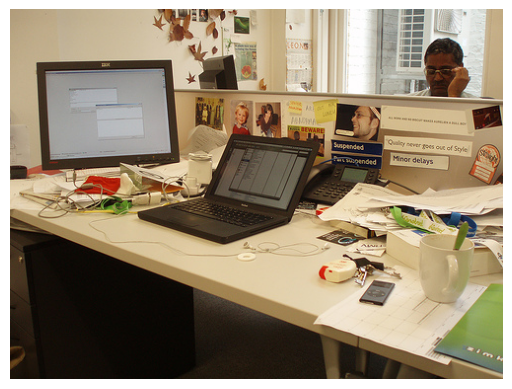

In [81]:
#generate a random number from 0 to 18906
query_index = np.random.randint(0,18906)
print(query_index)
random_img = image_list[query_index]
search_img = random_img
#display the image
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(search_img), cv2.COLOR_BGR2RGB))
plt.show()

In [84]:
#extract features from the search image
feat_vec = feature_extract_vgg16.extractFeat(search_img)
#expand the dimension of the feature vector
feat_vec = np.expand_dims(feat_vec, axis=0)
k = 6
start_time = time.time()
D, I = index_vgg.search(feat_vec, k)
end_time = time.time()
print('Search Time in L2: ', end_time - start_time)

start_time = time.time()
D1,I1 = index_ivf.search(feat_vec, k)
end_time = time.time()
print('Search Time in IVF: ', end_time - start_time)

1/1 [==============================] - 0s 175ms/step
Search Time in L2:  0.0036630630493164062
Search Time in IVF:  0.0025768280029296875


Height: 224
Width: 224
SSIM: 1.0
MSE: 0.0
SSIM: 0.24787322708797774
MSE: 9596.528878348214
SSIM: 0.12167792492626385
MSE: 9241.98828125
SSIM: 0.271546956669758
MSE: 8277.273258131378
SSIM: 0.3073716696299448
MSE: 11892.546954719388


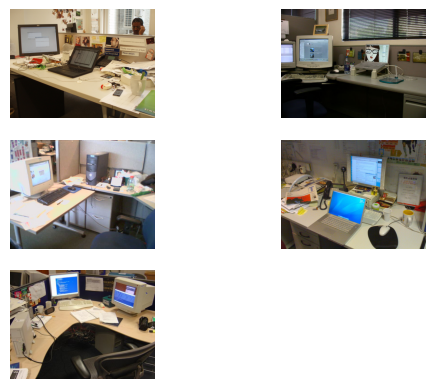

In [86]:
search_image = cv2.imread(search_img)
search_image = cv2.resize(search_image, (224, 224))
search_image_gray = cv2.cvtColor(search_image, cv2.COLOR_BGR2GRAY)
height, width = search_image_gray.shape

# Print dimensions
print("Height:", height)
print("Width:", width)

select_file_list = name_list_vgg[I[0][0:5]]
fig = plt.Figure(figsize=(3, 3))
image_titles = []
for i,file_name in enumerate(select_file_list):
    image_titles.append(file_name)
    # image path
    file_name = '/Users/shanghuahao/Desktop/RiceU/COMP646/Final_Project/Images/JPEGImages/'+file_name+'.jpg'
    
    # read image
    img = cv2.imread(file_name)
    # plot image
    plt.subplot(3, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    #compare image
    img_resize = cv2.resize(img, (224, 224))
    img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape

    # Print dimensions
    # print("Height:", height)
    # print("Width:", width)

    ssim_score = ssim(search_image, img_resize, multichannel=True,channel_axis=0, win_size=3)
    mse_score = mse(search_image_gray, img_gray)
    print("SSIM: {}".format(ssim_score))
    print("MSE: {}".format(mse_score))
plt.show()


SSIM: 0.24787322708797774
MSE: 9596.528878348214
SSIM: 0.12167792492626385
MSE: 9241.98828125
SSIM: 0.271546956669758
MSE: 8277.273258131378
SSIM: 0.3073716696299448
MSE: 11892.546954719388


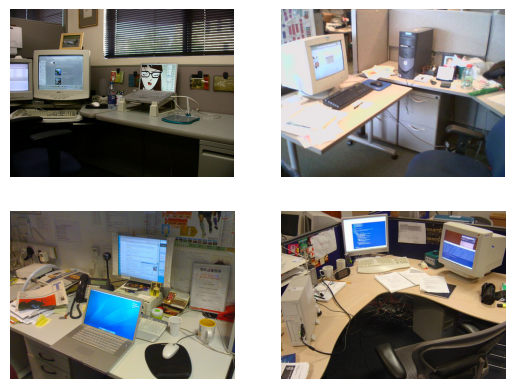

In [96]:
select_file_list = name_list_vgg[I1[0][1:5]]
fig = plt.Figure(figsize=(3, 3))
image_titles = []
for i,file_name in enumerate(select_file_list):
    image_titles.append(file_name)
    # image path
    file_name = '/Users/shanghuahao/Desktop/RiceU/COMP646/Final_Project/Images/JPEGImages/'+file_name+'.jpg'
    
    # read image
    img = cv2.imread(file_name)
    # plot image
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    #compare image
    img_resize = cv2.resize(img, (224, 224))
    img_gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape

    # Print dimensions
    # print("Height:", height)
    # print("Width:", width)

    ssim_score = ssim(search_image, img_resize, multichannel=True,channel_axis=0, win_size=3)
    mse_score = mse(search_image_gray, img_gray)
    print("SSIM: {}".format(ssim_score))
    print("MSE: {}".format(mse_score))
plt.show()

In [93]:
#compare the speed of L2 and IVF
L2_time = []
for i in range(500):
    rand_num = np.random.randint(0,18906)
    search_img = image_list[rand_num]
    feat_vec = feature_extract_vgg16.extractFeat(search_img)
    feat_vec = np.expand_dims(feat_vec, axis=0)
    k = 6
    start_time = time.time()
    D, I = index_vgg.search(feat_vec, k)
    end_time = time.time()
    L2_time.append(end_time - start_time)
print('L2 Time: ', np.mean(L2_time))

IVF_time = []
for i in range(500):
    rand_num = np.random.randint(0,18906)
    search_img = image_list[rand_num]
    feat_vec = feature_extract_vgg16.extractFeat(search_img)
    feat_vec = np.expand_dims(feat_vec, axis=0)
    k = 6
    start_time = time.time()
    D, I = index_ivf.search(feat_vec, k)
    end_time = time.time()
    IVF_time.append(end_time - start_time)
print('IVF Time: ', np.mean(IVF_time))

1/1 [==============================] - 0s 156ms/step
L2 Time:  0.0033118886947631834
1/1 [==============================] - 0s 166ms/step
IVF Time:  0.00026362848281860353


L2 Time:  0.0033118886947631834
IVF Time:  0.00026362848281860353
[0.07731009 0.08120728 0.08472419 0.08804202 0.09192514 0.09498501
 0.09818578 0.10205984 0.10521293 0.10825992 0.11109614 0.11409903
 0.11697817 0.12003803 0.12308288 0.12641907 0.12955904 0.13259315
 0.13603902 0.14033008 0.14359927 0.14669132 0.14961553 0.15307164
 0.15610528 0.15928626 0.16252828 0.1657052  0.16869712 0.17173409
 0.17503595 0.1779232  0.18102503 0.18388414 0.18724108 0.19020891
 0.1934576  0.19640946 0.20000958 0.2027998  0.20650291 0.21033096
 0.21378183 0.21687174 0.21969366 0.22273684 0.22583079 0.2285738
 0.23191547 0.23477149 0.23765635 0.24057627 0.24342418 0.24633217
 0.24929523 0.25218725 0.25582623 0.25905228 0.26194334 0.26508451
 0.26851535 0.27183151 0.27485442 0.27789545 0.28100967 0.28403664
 0.28724194 0.29150319 0.29461122 0.29765511 0.30068707 0.30402827
 0.30706811 0.31038022 0.31343508 0.31652641 0.31963539 0.32264853
 0.32587647 0.3288846  0.33188581 0.3349359  0.33795476 0.341272

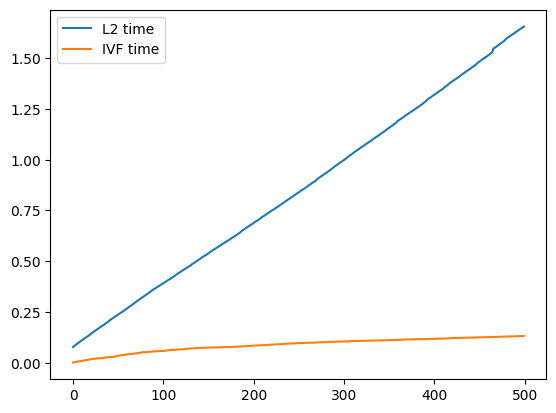

In [124]:
print('L2 Time: ', np.mean(L2_time))
print('IVF Time: ', np.mean(IVF_time))
L2_time_accumulate = np.cumsum(L2_time)
IVF_time_accumulate = np.cumsum(IVF_time)
print(L2_time_accumulate)
print(IVF_time_accumulate)
#draw a line chart to compare the speed of L2 and IVF
plt.plot(L2_time_accumulate, label='L2 time')
plt.plot(IVF_time_accumulate, label='IVF time')
plt.legend()
plt.show()

1/1 [==============================] - 0s 178ms/step
SSIM: 0.13490292329274858
MSE: 12253.975944674745
SSIM: 0.22024926317557875
MSE: 12253.975944674745
SSIM: 0.14239388991727503
MSE: 12253.975944674745
SSIM: 0.0067395748439308244
MSE: 12253.975944674745
1/1 [==============================] - 0s 180ms/step
SSIM: 0.1732928054033779
MSE: 12623.767578125
SSIM: 0.33900532814710616
MSE: 12623.767578125
SSIM: 0.1064719116857975
MSE: 12623.767578125
SSIM: 0.20752113764179475
MSE: 12623.767578125
1/1 [==============================] - 0s 167ms/step
SSIM: 0.31206266519831355
MSE: 8997.631556919643
SSIM: 0.4914024471287142
MSE: 8997.631556919643
SSIM: 0.23732610753640632
MSE: 8997.631556919643
SSIM: 0.10181628682898773
MSE: 8997.631556919643
1/1 [==============================] - 0s 170ms/step
SSIM: 0.3062874302382169
MSE: 7534.5546875
SSIM: 0.17558899274039286
MSE: 7534.5546875
SSIM: 0.26450352719326714
MSE: 7534.5546875
SSIM: 0.22172924154950333
MSE: 7534.5546875
1/1 [=========================

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

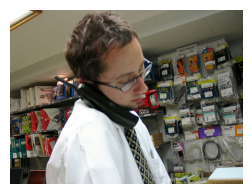

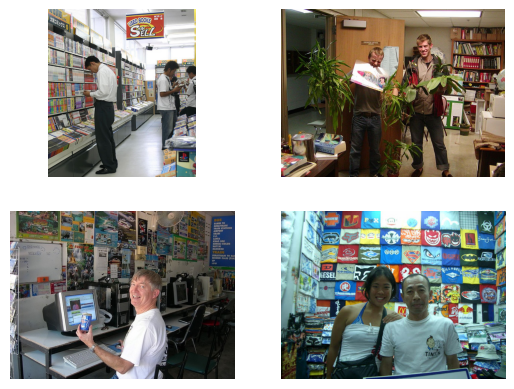

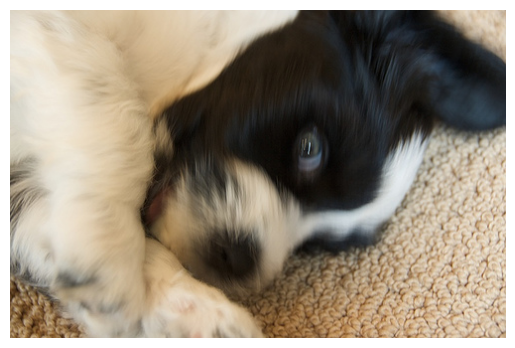

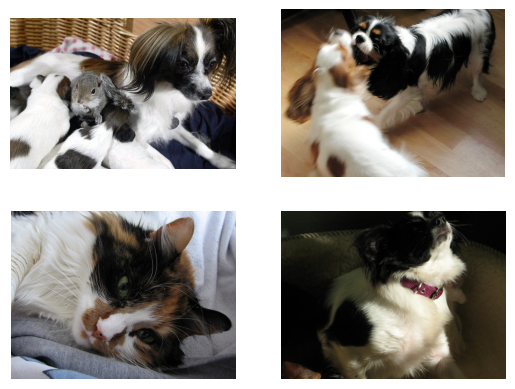

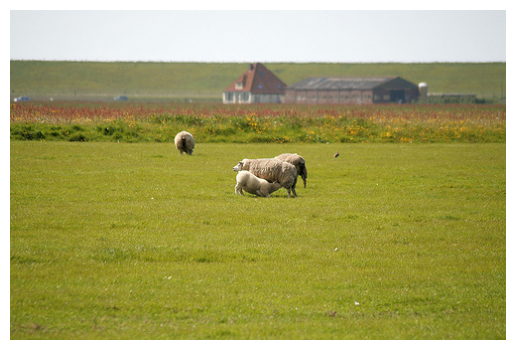

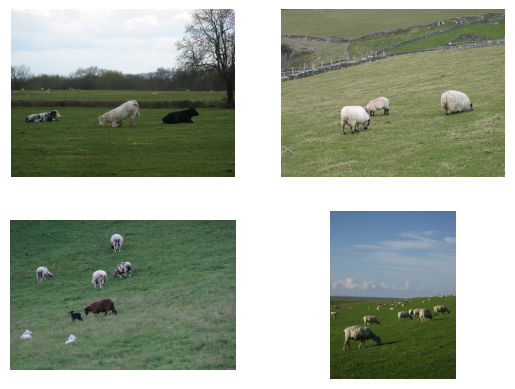

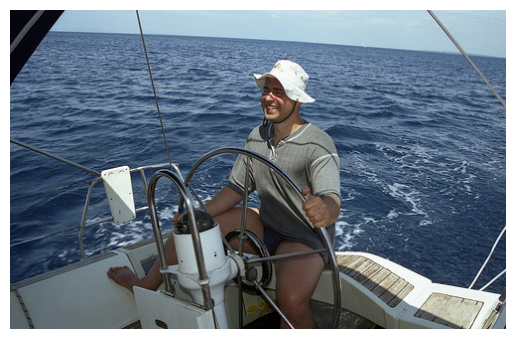

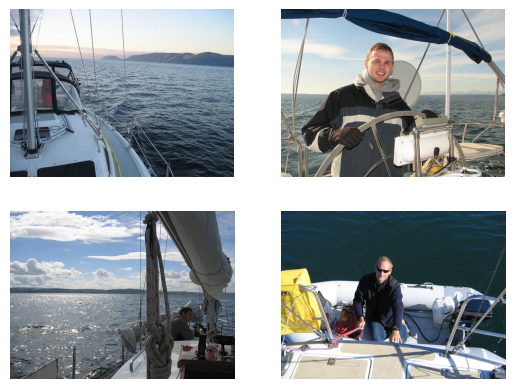

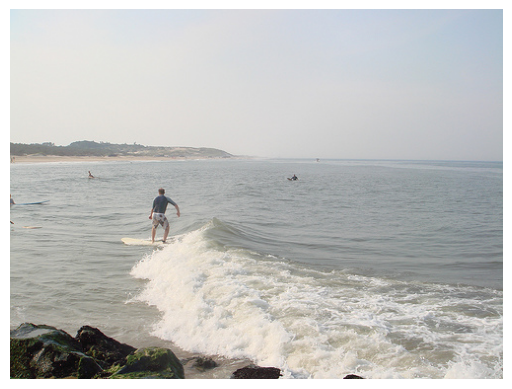

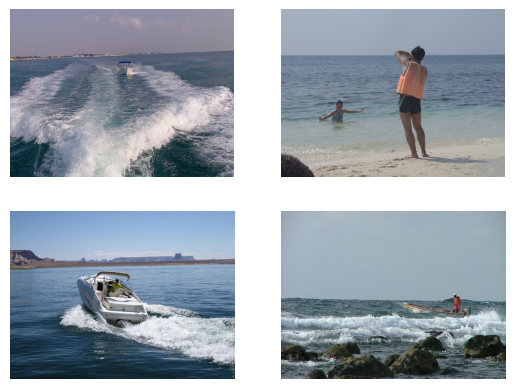

<Figure size 640x480 with 0 Axes>

In [144]:
#select 5 images from the dataset in random and search the similar images
fig_list = []
fig_list.append(plt.figure(figsize=(3, 3)))
fig_list.append(plt.figure(figsize=(3, 3)))
fig_list.append(plt.figure(figsize=(3, 3)))
fig_list.append(plt.figure(figsize=(3, 3)))
fig_list.append(plt.figure(figsize=(3, 3)))
for i in range(5):
    rand_num = np.random.randint(0,18906)
    search_img_path = image_list[rand_num]
    #display the search image
    search_img = cv2.imread(search_img_path)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(search_img, cv2.COLOR_BGR2RGB))
    feat_vec = feature_extract_vgg16.extractFeat(search_img_path)
    feat_vec = np.expand_dims(feat_vec, axis=0)
    k = 6
    D, I = index_ivf.search(feat_vec, k)
    select_file_list = name_list_vgg[I[0][1:5]]
    image_titles = []
    search_img = cv2.resize(search_img, (224, 224))
    search_img_gray = cv2.cvtColor(search_img, cv2.COLOR_BGR2GRAY)
    plt.figure()
    for i,file_name in enumerate(select_file_list):
        image_titles.append(file_name)
        # image path
        file_name = '/Users/shanghuahao/Desktop/RiceU/COMP646/Final_Project/Images/JPEGImages/'+file_name+'.jpg'
        
        # read image
        img = cv2.imread(file_name)
        img_resize = cv2.resize(img, (224, 224))
        ssim_score = ssim(search_img, img_resize, multichannel=True,channel_axis=0, win_size=3)
        mse_score = mse(search_img_gray, img_gray)
        print("SSIM: {}".format(ssim_score))
        print("MSE: {}".format(mse_score))
        # plot image
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.figure()




SSIM: -0.10288987522587248
MSE: 7439.654157366072
SSIM: 0.13360147369060024
MSE: 7439.654157366072
SSIM: 0.11690203194747896
MSE: 7439.654157366072
SSIM: 0.19635097793498396
MSE: 7439.654157366072


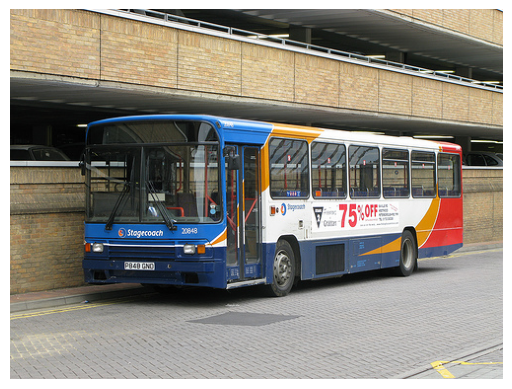

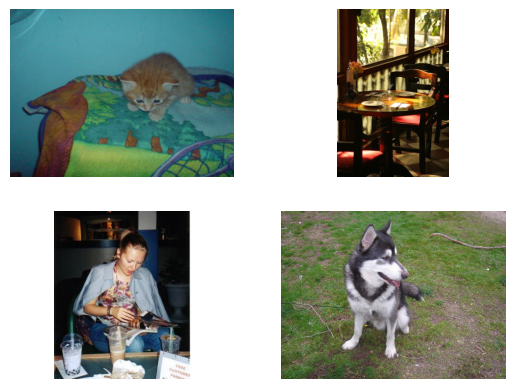

In [142]:
rand_num1 = np.random.randint(0,18906)
rand_num2 = np.random.randint(0,18906)
rand_num3 = np.random.randint(0,18906)
rand_num4 = np.random.randint(0,18906)
rand_num5 = np.random.randint(0,18906)
rand_img1 = image_list[rand_num1]
rand_img2 = image_list[rand_num2]
rand_img3 = image_list[rand_num3]
rand_img4 = image_list[rand_num4]
rand_img5 = image_list[rand_num5]
rand_img1 = cv2.imread(rand_img1)
rand_img2 = cv2.imread(rand_img2)
rand_img3 = cv2.imread(rand_img3)
rand_img4 = cv2.imread(rand_img4)
rand_img5 = cv2.imread(rand_img5)
imgs = [ rand_img2, rand_img3, rand_img4, rand_img5]
plt.axis('off')
plt.imshow(cv2.cvtColor(rand_img1, cv2.COLOR_BGR2RGB))
plt.figure()
rand_img1_resize = cv2.resize(rand_img1, (224, 224))
rand_img1_gray = cv2.cvtColor(rand_img1, cv2.COLOR_BGR2GRAY)
for i,img in enumerate(imgs):
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    img_resize = cv2.resize(img, (224, 224))
    ssim_score = ssim(rand_img1_resize, img_resize, multichannel=True,channel_axis=0, win_size=3)

    print("SSIM: {}".format(ssim_score))
    print("MSE: {}".format(mse_score))